In [1]:
from typing import Any, Dict, List, Mapping, Sequence, Set, Text

import pandas as pd
import numpy as np
import math
import json
import re
import requests
import time

In [2]:
SKIP_MAFS = True

# Exploratory analysis of CSV data retrieved from GWAS Catalog.
This specific data is for Schizophrenia, but other data in GWAS catalog can be retrieved in the same format.

## Exploring raw data types, range of data, etc.

### Overall

In [3]:
raw_schizo_df = pd.read_csv('schizophrenia_gwas_catalog_2022.csv')
raw_schizo_df.head()

,Variant and risk allele,P-value,P-value annotation,RAF,OR,Beta,CI,Mapped gene,Reported trait,Trait(s),Background trait(s),Study accession,Location
0,rs11265461-<b>C</b>,2 x 10-7,NaN,0.41,1.45,'-,[1.26-1.67],"SLAMF1, SETP9",Schizophrenia (treatment resistant),treatment refractory schizophrenia,'-,GCST001458,1:160660353
1,rs230529-<b>T</b>,2 x 10-7,NaN,0.47,1.45,'-,[1.26-1.66],NFKB1,Schizophrenia (treatment resistant),treatment refractory schizophrenia,'-,GCST001458,4:102536261
2,rs2237457-<b>T</b>,6 x 10-7,(Recessive model),0.36,1.74,'-,[NR],GRB10,Schizophrenia (treatment resistant),treatment refractory schizophrenia,'-,GCST002604,7:50658447
3,rs2269372-<b>A</b>,4 x 10-8,NaN,NR,1.313,'-,[NR],RENBP,Schizophrenia,schizophrenia,'-,GCST002190,X:153942092
4,rs7597593-<b>T</b>,9 x 10-11,NaN,NR,1.066,'-,[1.05-1.09],ZNF804A,Schizophrenia,schizophrenia,'-,GCST004946,2:184668853


In [4]:
total_rows = len(raw_schizo_df)
print(total_rows)

3849


According to https://www.ebi.ac.uk/gwas/docs/methods/curation
- 
"RISK ALLELE FREQUENCY: Reported risk/effect allele frequency associated with strongest SNP in controls (if not available among all controls, among the control group with the largest sample size). If the associated locus is a haplotype the haplotype frequency will be extracted."
So RAF is not global AF, but rather that of the study group. Since this are less comparable across studies, we'll lookup global AF for variants.

### Variants

In [5]:
num_unique_variants = len(raw_schizo_df['Variant and risk allele'].unique())
print(f"{num_unique_variants} unique variants out of {total_rows} records.")

variant_counts = raw_schizo_df['Variant and risk allele'].value_counts()

2739 unique variants out of 3849 records.


In [6]:
# Explore entries for one repeated variant to assess differences.
duplicates = raw_schizo_df.groupby('Variant and risk allele').filter(lambda x: len(x) > 1)
one_variant = duplicates.iloc[0]['Variant and risk allele']
duplicates[duplicates['Variant and risk allele'] == one_variant]

,Variant and risk allele,P-value,P-value annotation,RAF,OR,Beta,CI,Mapped gene,Reported trait,Trait(s),Background trait(s),Study accession,Location
4,rs7597593-<b>T</b>,9 x 10-11,NaN,NR,1.066,'-,[1.05-1.09],ZNF804A,Schizophrenia,schizophrenia,'-,GCST004946,2:184668853
747,rs7597593-<b>T</b>,2 x 10-11,NaN,NR,1.069,'-,[1.05-1.09],ZNF804A,Schizophrenia,schizophrenia,'-,GCST007201,2:184668853
2878,rs7597593-<b>T</b>,3 x 10-12,NaN,0.62,'-,'-,'-,ZNF804A,Broad depression or schizophrenia,"unipolar depression, schizophrenia",'-,GCST007257,2:184668853
3625,rs7597593-<b>T</b>,8 x 10-6,(5 degree of freedom test),NR,1.055,'-,[1.03-1.08],ZNF804A,"Autism spectrum disorder, attention deficit-hy...","attention deficit hyperactivity disorder, unip...",'-,GCST001877,2:184668853


### P-values

In [7]:
raw_schizo_df['P-value'].describe()

count         3849
unique         163
top       2 x 10-8
freq           201
Name: P-value, dtype: object

In [8]:
len(raw_schizo_df['Mapped gene'].unique())

1427

### Genes

In [9]:
def has_multiple_genes(mapped_gene):
  return "," in mapped_gene


multi_gene_index = raw_schizo_df['Mapped gene'].apply(has_multiple_genes)
len(raw_schizo_df[multi_gene_index])

913

### Reported trait / Trait(s)

In [10]:
raw_schizo_df['Reported trait'].unique()

array(['Schizophrenia (treatment resistant)', 'Schizophrenia',
       'Schizophrenia (MTAG)', 'Schizophrenia or bipolar disorder',
       'Schizophrenia (negative symptoms)', 'Methamphetamine dependence',
       'Early-onset schizophrenia',
       'Autism spectrum disorder or schizophrenia',
       'Gray matter volume (schizophrenia interaction)',
       'Schizophrenia (inflammation and infection response interaction)',
       'Broad depression or schizophrenia',
       'Dentate gyrus volume x schizophrenia interaction',
       'Schizophrenia vs type 2 diabetes',
       'Schizophrenia and type 2 diabetes',
       'Autism and schizophrenia (MTAG)',
       'Left superior temporal gyrus thickness (schizophrenia interaction)',
       'Bipolar disorder and schizophrenia',
       'Schizophrenia (cytomegalovirus infection interaction)',
       'Schizophrenia (age at onset)',
       'Schizophrenia or schizoaffective disorder',
       'Schizophrenia vs autism spectrum disorder (ordinary least s

In [11]:
raw_schizo_df['Trait(s)'].unique()

array(['treatment refractory schizophrenia', 'schizophrenia',
       'autism spectrum disorder, schizophrenia',
       'schizophrenia, grey matter volume measurement',
       'schizophrenia, cytomegalovirus seropositivity',
       'schizophrenia, HSV1 seropositivity',
       'schizophrenia, Toxoplasma gondii seropositivity',
       'unipolar depression, schizophrenia',
       'dentate gyrus volume measurement, schizophrenia',
       'schizophrenia, type 2 diabetes mellitus',
       'schizophrenia, bipolar disorder',
       'schizophrenia, left superior temporal gyrus thickness measurement',
       'schizophrenia, cytomegalovirus infection',
       'schizophrenia, age at onset',
       'schizophrenia, schizoaffective disorder',
       'anorexia nervosa, schizophrenia',
       'attention deficit hyperactivity disorder, schizophrenia',
       'Tourette syndrome, schizophrenia',
       'schizophrenia, sex interaction measurement',
       'schizophrenia, bipolar disorder, response to lithiu

In [12]:
num_just_schizo = len(raw_schizo_df[raw_schizo_df['Trait(s)'] == 'schizophrenia'])
print(f"{num_just_schizo} / {total_rows} rows are for the trait schizophrenia only.")

2564 / 3849 rows are for the trait schizophrenia only.


### Initial observations:


*   3849 records total
*   P-values are currently objects/strings
*   A lot of genes - 1427 unique values, although some normalization seems to be required (e.g. to fix "SLAMF1, SETP9"). After normalizing it may be good to analyze counts per gene - maybe genes only implicated once are less signficant than others which appear multiple times.
*   Many records have multiple traits in addition to schizophrenia (e.g. one trait value is "anorexia nervosa, obsessive-compulsive disorder, attention deficit hyperactivity disorder, Tourette syndrome, unipolar depression, autism spectrum disorder, schizophrenia, bipolar disorder"). I assume these studies examined patients with either condition, but it's not entirely clear without checking the studies themselves. To make this a scalable approach, it may be best to omit records that are for more than just schizophrenia to avoid any potential biases in the future similarity analysis.
* A fair amount of the variants in the dataset appear multiple times (e.g. reported by different studies). It's worth noting this, although at the moment it's unclear what the best way to handle this is. Maybe subsequent analysis should only focus on variants identified multiple time; maybe for each repeated variant, only the lowest p-value should be retained. However, some care should be applied given the above point about traits (maybe want the lowest p-value among records for just the trait schizophrenia).



## Cleaning/normalizing data

In [13]:
# Create copy of DF to hold normalized data and leave raw DF untouched.
schizo_df = raw_schizo_df.copy()

### P-values

In [14]:
def pval_to_num(pval):
  parts = pval.split(" x 10-")
  return float(parts[0]) * pow(10, -float(parts[1]))


print(pval_to_num("2 x 10-7"))

2e-07


In [15]:
schizo_df['P-value_norm'] = raw_schizo_df['P-value'].apply(pval_to_num)

In [16]:
schizo_df['P-value_norm'].describe()

count    3.849000e+03
mean     1.072234e-06
std      2.255918e-06
min      2.000000e-44
25%      3.000000e-10
50%      2.000000e-08
75%      6.000000e-07
max      1.000000e-05
Name: P-value_norm, dtype: float64

### Traits

In [17]:
# As mentioned above, it may be best to use the subset of data which focused 
# solely on the trait of interest (schizophrenia).
# There are some others that are probably fine to include (e.g. treatment 
# refractory schizophrenia), but for the sake of simplicity and 
# generalizability, we'll assume there is one canonical GWAS catalog trait of 
# interest for each condition to be analyzed.
canonical_trait = 'schizophrenia'
filtered_df = schizo_df[schizo_df['Trait(s)'] == canonical_trait]
print(f"Filtered from {len(schizo_df)} rows to {len(filtered_df)} rows.")

Filtered from 3849 rows to 2564 rows.


In [18]:
# The majority of the data is retained, so we'll use just this subset.
schizo_df = filtered_df

### Variants

In [19]:
# Sanity-check that all duplicated variants are reported to map to same gene(s)
# before we split multi-gene associations into separate rows.
# If all repeated variants map to same gene, we can just retain the entry with
# lowest p-value (or any really, since subsequent analysis just cares about 
# variant ID and implicated genes).
duplicate_variants = schizo_df.groupby('Variant and risk allele').filter(lambda x: len(x) > 1)['Variant and risk allele'].unique()
all_good = True
for variant in duplicate_variants:
  all_mapped_genes = schizo_df[schizo_df['Variant and risk allele'] == variant]['Mapped gene'].unique()
  if len(all_mapped_genes) > 1:
    print(f"Found variant, {variant}, with differing mapped gene values.")
    all_good = False


if all_good:
  print("No repeated variants with differing mapped gene values.")

No repeated variants with differing mapped gene values.


In [20]:
# Proceed with just choosing the record with the lowest p-value.
# It may later be useful to revisit this step and retain these duplicates - 
# maybe only focusing on those associations that have been found in multiple
# independent studies will lead to better results in the subsequent analysis.
min_indices = schizo_df.groupby('Variant and risk allele')['P-value_norm'].idxmin()
schizo_df = schizo_df.loc[min_indices]

In [21]:
# Sanity-check duplicates are gone:
num_unique_variants = len(schizo_df['Variant and risk allele'].unique())
num_total = len(schizo_df)
print(f"{num_unique_variants} unique variants of {num_total} records")

1822 unique variants of 1822 records


### Genes

In [22]:
# Genes are comma-separated so `explode` can be used to create a new row for 
# each gene (with all other columns identical).
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html
schizo_df['gene_norm'] = raw_schizo_df['Mapped gene'].apply(lambda val: val.split(", "))
exploded_schizo_df = schizo_df.explode('gene_norm')
len(exploded_schizo_df)

2201

In [23]:
# Sanity check that the final number of rows is expected:
schizo_df['gene_norm'].apply(lambda x: len(x)).value_counts()

1    1444
2     377
3       1
Name: gene_norm, dtype: int64

In [24]:
# 1444 entries with one gene + 2 * 377 entries with two + 3 * 1 entries with three
assert len(exploded_schizo_df) == 1444 + 2 * 377 + 3 * 1

In [25]:
# Sanity-check passes so set schizo_df to the exploded version.
schizo_df = exploded_schizo_df

In [26]:
schizo_df['gene_norm'].value_counts()

'-           251
LINC01470     21
CACNA1C       15
Y_RNA         15
VRK2          11
            ... 
ARHGAP31       1
ADAMTS6        1
NLRC5          1
VN1R18P        1
NRIP1          1
Name: gene_norm, Length: 1118, dtype: int64

In [27]:
# 491 / 4764 entries have "'-" for their gene; I'm assuming this indicates an 
# unknown/unconfirmed gene association. According to curation site, it says
# 'NR' is used for not reported and 'intergenic' is used to denote intergenic 
# regions, but neither of these appear in this data
UNKNOWN_GENE = "UNKNOWN"

def replace_unknown_gene(gene):
  return UNKNOWN_GENE if gene == "'-" else gene


schizo_df['gene_norm'] = schizo_df['gene_norm'].apply(replace_unknown_gene)
schizo_df['gene_norm'].value_counts()

UNKNOWN      251
LINC01470     21
CACNA1C       15
Y_RNA         15
VRK2          11
            ... 
ARHGAP31       1
ADAMTS6        1
NLRC5          1
VN1R18P        1
NRIP1          1
Name: gene_norm, Length: 1118, dtype: int64

In [28]:
unique_genes = schizo_df['gene_norm'].unique()
'NR' in unique_genes or 'intergenic' in unique_genes

False

### Location

In [29]:
# Location is mostly fine. Some associations don't report an rs ID in 'Variant 
# and risk allele' and instead report in the format 'chrX:location-<b>?</b>',
# and then their Location value is 'Mapping not available'. Just copy over the
# location info in same format as other variants. Note some rs ID variants also
# use 'Mapping not available' though, so leave those as is.
NON_RSVAR_FORMAT_LOCATION_VALUE = 'Mapping not available'


def try_fix_variant_location(variant_row: pd.Series) -> Text:
  """Given variants of form 'chr6:55564517-<b>?</b>' returns '6:55564517'."""
  if variant_row['Location'] != NON_RSVAR_FORMAT_LOCATION_VALUE:
    return variant_row['Location']
  variant = variant_row['Variant and risk allele']
  if 'rs' in variant:
    return NON_RSVAR_FORMAT_LOCATION_VALUE
  parts = variant.split(":")
  chr_num = parts[0][3]
  location = parts[1].split("-")[0]
  return f'{chr_num}:{location}'


nonstandard_variants_df = schizo_df.loc[schizo_df['Location'] == NON_RSVAR_FORMAT_LOCATION_VALUE]
print(f'{len(nonstandard_variants_df)} variants missing location info.')
schizo_df['Location'] = schizo_df.apply(try_fix_variant_location, axis=1)

still_missing_count = len(schizo_df.loc[schizo_df['Location'] == NON_RSVAR_FORMAT_LOCATION_VALUE])
print(f'{still_missing_count} variants still missing location info.')

130 variants missing location info.
129 variants still missing location info.


## Output

Finally, write out the normalized version of the data for use
in further analysis.

In [30]:
schizo_df.head()

,Variant and risk allele,P-value,P-value annotation,RAF,OR,Beta,CI,Mapped gene,Reported trait,Trait(s),Background trait(s),Study accession,Location,P-value_norm,gene_norm
2388,chr6:55564517-<b>?</b>,3 x 10-6,(female),0.5665,'-,0.1622 unit increase,[0.094-0.23],'-,Schizophrenia,schizophrenia,'-,GCST012309,6:55564517,3.000000e-06,UNKNOWN
1176,rs1001780-<b>G</b>,8 x 10-6,NaN,NR,1.0752687,'-,[NR],DLX2-DT,Schizophrenia,schizophrenia,'-,GCST003048,2:172107630,8.000000e-06,DLX2-DT
2036,rs10043984-<b>?</b>,5 x 10-8,NaN,'-,'-,'-,'-,KDM3B,Schizophrenia (MTAG),schizophrenia,'-,GCST010640,5:138376432,5.000000e-08,KDM3B
615,rs10043984-<b>T</b>,4 x 10-8,NaN,0.2614,'-,0.067151085 unit increase,[0.043-0.091],KDM3B,Schizophrenia (MTAG),schizophrenia,'-,GCST012089,5:138376432,4.000000e-08,KDM3B
236,rs10046758-<b>?</b>,9 x 10-8,NaN,NR,'-,'-,'-,CSMD1,Schizophrenia,schizophrenia,'-,GCST008459,8:4326648,9.000000e-08,CSMD1


In [31]:
# Keep only the relevant, normalized columns for brevity. This can always be 
# updated later to retain more if there's a use for it.

out_df = schizo_df[['Variant and risk allele', 'P-value_norm', 'Trait(s)', 'gene_norm', 'Location']]
column_remapping = {
    'Variant and risk allele': 'variant_and_allele', 
    'P-value_norm': 'p_value',
    'Trait(s)': 'trait',
    'gene_norm': 'gene',
    'Location': 'location',
}
out_df = out_df.rename(columns=column_remapping)
out_df.head()

,variant_and_allele,p_value,trait,gene,location
2388,chr6:55564517-<b>?</b>,3.000000e-06,schizophrenia,UNKNOWN,6:55564517
1176,rs1001780-<b>G</b>,8.000000e-06,schizophrenia,DLX2-DT,2:172107630
2036,rs10043984-<b>?</b>,5.000000e-08,schizophrenia,KDM3B,5:138376432
615,rs10043984-<b>T</b>,4.000000e-08,schizophrenia,KDM3B,5:138376432
236,rs10046758-<b>?</b>,9.000000e-08,schizophrenia,CSMD1,8:4326648


In [32]:
out_df.to_csv('schizophrenia_gwas_catalog_2022_cleaned.csv')

# Load auxiliary data from dbSNP

In [33]:
DB_SNP = 'snp'

# dbsnp efetch max refsnp results:
MAX_DBSNP_QUERIES = 15

# dbsnp API min time between requests.
SLEEP_SECONDS = 3

SUBCOL_DELIM = ';'

# Use this study for reporting population mean allele frequency (MAF).
PREFFERED_AF_STUDY = 'dbGaP_PopFreq'

# Given a dbSNP ID, fetches allele frequency data about the SNP from dbSNP.
# Returns a dict of dicts, where outer key is SNP ID, inner dict key is allele,
# and value is MAF for that allele for that SNP.
def get_mafs_for_refsnps(snp_ids):
    start = 0
    stop = len(snp_ids)
    data = {}
    while start < stop:
        cutoff = start + MAX_DBSNP_QUERIES
        cutoff = min(stop, cutoff)
        time.sleep(SLEEP_SECONDS)
        data_batch = _get_mafs_for_refsnps_internal(snp_ids[start:cutoff])
        # Pythonic way to merge dicts (3.5+)
        data = {**data, **data_batch}
        start += MAX_DBSNP_QUERIES
    return data


# Wrapped to avoid exceeding API request/response size limitations.
def _get_mafs_for_refsnps_internal(snp_ids):
    url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi'
    params = {
        'db': DB_SNP,
        'id': snp_ids,
        'rettype': 'json',
        'retmode': 'text',
    }

    maf_dicts = {}
    request = requests.get(url=url, params=params)
    parseable_json = '[{' + request.text[1:].replace('{"refsnp_id":', ',{"refsnp_id":') + ']'
    response = json.loads(parseable_json)
    for snp_response in response:
        if 'primary_snapshot_data' not in snp_response:
            continue

        snp_id = 'rs' + snp_response['refsnp_id']
        allele_to_maf = {}
        allele_annotations = snp_response['primary_snapshot_data']['allele_annotations']
        for allele_annotation in allele_annotations:
            frequencies = allele_annotation['frequency']
            pop_freq_entries = [entry for entry in frequencies if entry['study_name'] == PREFFERED_AF_STUDY]
            if len(pop_freq_entries) == 0:
              continue
            pop_freq_entry = pop_freq_entries[0]
            pop_maf = pop_freq_entry['allele_count'] / pop_freq_entry['total_count']
            allele = pop_freq_entry['observation']['inserted_sequence']
            allele_to_maf[allele] = pop_maf
        # Sometimes all alleles are reported, even with 0.0 values.
        # Drop those, assuming they are truly 0 and should be ignored.
        allele_to_maf = {key: value for key, value in allele_to_maf.items() if value > 0.0}
        maf_dicts[snp_id] = allele_to_maf
        
    return maf_dicts

In [34]:
all_variants = out_df['variant_and_allele'].tolist()
rs_variants_and_alleles = [var for var in all_variants if 'rs' in var]
other_variants = [var for var in all_variants if var not in rs_variants_and_alleles]

print(f"{len(rs_variants_and_alleles)} rs variants out of {len(all_variants)} total variants")

2200 rs variants out of 2201 total variants


In [35]:
print(other_variants)

['chr6:55564517-<b>?</b>']


In [36]:
ALLELE_REGEX_PATTERN = r"<b>(.*)</b>"


def parse_variant_and_allele(variant_and_allele):
  """Given a string like 'rs1001780-<b>G</b>', returns ('rs1001780', 'G')."""
  parts = variant_and_allele.split("-")
  variant = parts[0]
  allele = re.findall(ALLELE_REGEX_PATTERN, parts[1], flags=0)[0]
  return (variant, allele)


def parse_variant(variant_and_allele):
  """Given a string like 'rs1001780-<b>G</b>', returns 'rs1001780'."""
  return parse_variant_and_allele(variant_and_allele)[0]


rs_variants = [parse_variant(var) for var in rs_variants_and_alleles]

In [37]:
rs_variants[0:10]

['rs1001780',
 'rs10043984',
 'rs10043984',
 'rs10046758',
 'rs10052004',
 'rs1006737',
 'rs1006737',
 'rs10077591',
 'rs10077591',
 'rs10083370']

In [38]:
# Demo
mafs = get_mafs_for_refsnps(rs_variants[0:5])
mafs

{'rs1001780': {'G': 0.907379924446843, 'T': 0.09262007555315704},
 'rs10043984': {'C': 0.745363299149029, 'T': 0.25463670085097095},
 'rs10046758': {'C': 0.8966909848879625, 'G': 0.10330901511203752},
 'rs10052004': {'A': 0.29921583447493977, 'G': 0.7007841655250602}}

In [39]:
# Takes ~45 minutes to run :|
mafs = get_mafs_for_refsnps(rs_variants)

In [40]:
UNKNOWN_AF = -1.0
# From https://www.ebi.ac.uk/gwas/docs/methods/curation
# "? for unknown risk allele"
UNKNOWN_ALLELE = '?'


def try_get_maf_for_variant_and_allele(variant_and_allele):
  variant, allele = parse_variant_and_allele(variant_and_allele)
  if variant not in mafs:
    return UNKNOWN_AF

  var_mafs = mafs[variant]
  if allele == UNKNOWN_ALLELE:
    # Assume the significant association to be with the allele with min value if
    # not reported explicitly when there are only two alleles.
    if len(var_mafs.keys()) == 2:
      return min(var_mafs.values())
    print(f'Found variant with no reported allele for non-biallelic variant.')
    return UNKNOWN_AF

  if allele not in var_mafs:
    return UNKNOWN_AF

  return var_mafs[allele]


out_df['maf'] = out_df['variant_and_allele'].map(try_get_maf_for_variant_and_allele)
out_df['maf'].describe()

Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.
Found variant with no reported allele for non-biallelic variant.


count    2201.000000
mean        0.346703
std         0.387918
min        -1.000000
25%         0.179093
50%         0.355426
75%         0.560081
max         1.000000
Name: maf, dtype: float64

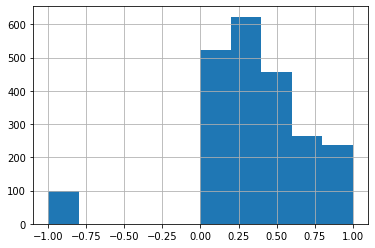

In [41]:
out_df['maf'].hist()

Text(0.5, 0, 'Risk allele frequency')

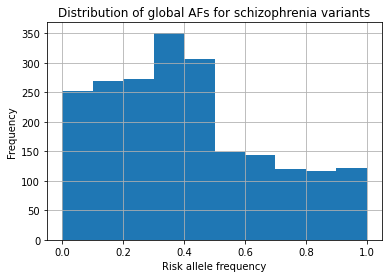

In [42]:
ax = out_df[out_df['maf'] > 0]['maf'].plot(kind='hist', 
                                      grid=True,
                                      title='Distribution of global AFs for schizophrenia variants')
ax.set_xlabel('Risk allele frequency')

Check out the alleles with unknown AFs:

In [43]:
unknowns = out_df[out_df['maf'] < 0.0]
len(unknowns)

99

In [44]:
unknowns.head()

,variant_and_allele,p_value,trait,gene,location,maf
2388,chr6:55564517-<b>?</b>,3.000000e-06,schizophrenia,UNKNOWN,6:55564517,-1.0
2008,rs1023330-<b>?</b>,9.000000e-09,schizophrenia,TLCD4-RWDD3,1:95121217,-1.0
2008,rs1023330-<b>?</b>,9.000000e-09,schizophrenia,TLCD4,1:95121217,-1.0
2083,rs1023497-<b>?</b>,9.000000e-09,schizophrenia,CENPM,22:41944504,-1.0
1847,rs10489202-<b>A</b>,1.000000e-08,schizophrenia,UNKNOWN,Mapping not available,-1.0


In [45]:
mafs['rs1023330']

{'A': 8.575226171590276e-06, 'C': 0.6589289542511684, 'T': 0.34106247052266003}

In [46]:
mafs['rs1023497']

{'C': 0.9115666616788868, 'G': 0.08805925482567709, 'T': 0.0003740834954361814}

In [47]:
mafs['rs10489202']

{'G': 0.7572409986349701, 'T': 0.24275900136502987}

Most seem to be tri-allelic and risk allele is not specified. Some don't appear to have data for the risk allele.

Also inspect the ones with AFs close to 1:

In [48]:
ones = out_df[out_df['maf'] > 0.99]
len(ones)

8

In [49]:
ones.head()

,variant_and_allele,p_value,trait,gene,location,maf
1230,rs117509195-<b>G</b>,5.000000e-06,schizophrenia,LINC00301,11:60619545,0.995525
575,rs12620761-<b>C</b>,2.000000e-06,schizophrenia,MGAT5,2:134096560,0.998044
1339,rs148114321-<b>T</b>,9.000000e-06,schizophrenia,RALGAPA1,14:35744236,0.992117
1412,rs190474885-<b>C</b>,1.000000e-06,schizophrenia,NT5C2,10:103213560,0.991070
894,rs60005721-<b>A</b>,8.000000e-09,schizophrenia,CMAHP,6:25262991,1.000000


In [50]:
mafs['rs60005721']

{'A': 1.0}

In [51]:
mafs['rs117509195']

{'C': 0.004475005457323728, 'G': 0.9955249945426763}

Interestingly, some of the reported risk alleles appear to be the dominant allele, not the minor alleles.

This means the assumption to choose the min AF for biallelic variants may not be correct. Fix that, even though a significant number of variants do not report the risk allele:

In [52]:
def try_get_maf_for_variant_and_allele(variant_and_allele):
  variant, allele = parse_variant_and_allele(variant_and_allele)
  if variant not in mafs:
    return UNKNOWN_AF

  var_mafs = mafs[variant]
  if allele == UNKNOWN_ALLELE or allele not in var_mafs:
    return UNKNOWN_AF

  return var_mafs[allele]


out_df['maf'] = out_df['variant_and_allele'].map(try_get_maf_for_variant_and_allele)
out_df['maf'].describe()

count    2201.000000
mean       -0.075961
std         0.753832
min        -1.000000
25%        -1.000000
50%         0.196713
75%         0.560081
max         1.000000
Name: maf, dtype: float64

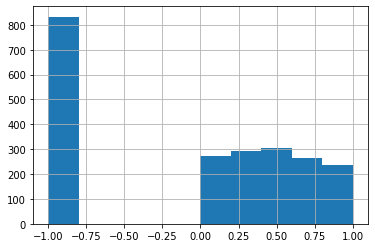

In [53]:
out_df['maf'].hist()

Text(0.5, 0, 'Risk allele frequency')

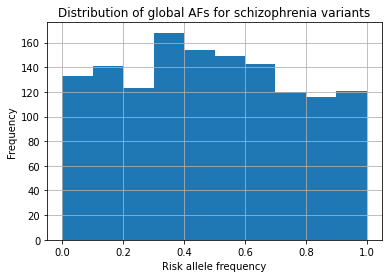

In [54]:
ax = out_df[out_df['maf'] > 0]['maf'].plot(kind='hist', 
                                      grid=True,
                                      title='Distribution of global AFs for schizophrenia variants')
ax.set_xlabel('Risk allele frequency')

In [55]:
unknowns = out_df[out_df['maf'] < 0.0]
print(f'{len(unknowns)} variants with unknown risk alleles out of {len(out_df)} total variants')

833 variants with unknown risk alleles out of 2201 total variants


# Join with cis-eQTL data
Join with processed lists of variants signficantly associated with genes in select tissues.

In [56]:
tissue_files = [
  'Adipose_Subcutaneous.significant_variant_locations.txt',
  'Adipose_Visceral_Omentum.significant_variant_locations.txt',
  'Adrenal_Gland.significant_variant_locations.txt',
  'Artery_Aorta.significant_variant_locations.txt',
  'Artery_Coronary.significant_variant_locations.txt',
  'Artery_Tibial.significant_variant_locations.txt',
  'Brain_Amygdala.significant_variant_locations.txt',
  'Brain_Anterior_cingulate_cortex_BA24.significant_variant_locations.txt',
  'Brain_Caudate_basal_ganglia.significant_variant_locations.txt',
  'Brain_Cerebellar_Hemisphere.significant_variant_locations.txt',
  'Brain_Cerebellum.significant_variant_locations.txt',
  'Brain_Cortex.significant_variant_locations.txt',
  'Brain_Frontal_Cortex_BA9.significant_variant_locations.txt',
  'Brain_Hippocampus.significant_variant_locations.txt',
  'Brain_Hypothalamus.significant_variant_locations.txt',
  'Brain_Nucleus_accumbens_basal_ganglia.significant_variant_locations.txt',
]

In [57]:
NON_RSVAR_FORMAT_LOCATION_VALUE = 'Mapping not available'
INVALID_LOCATION = 'Invalid variant location'


def gtex_location_to_gwas_location(gtex_location: Text) -> Text:
  """Converts variant locations in GWAS catalog format to GTEx format.
  
  i.e. given 'chr1_64764_C_T_b38', returns '4:79296443'.
  """
  parts = gtex_location.split("_")
  chr = parts[0][3]
  return f'{chr}:{parts[1]}'


def find_tissue_associations(variant_pos_set: Set, tissue_filepath: Text) -> Dict[Text, Text]:
  """Identifies variants with significant tissue associations.
  
  Returns:
      A dict mapping variant locations to tissue. Always same tissue per 
      function invocation, but idea is to merge later.
  """
  tissue_associations = {}
  tissue = tissue_filepath.split(".")[0]
  with open(tissue_filepath) as tissue_file:
    for variant_pos_with_allele in tissue_file.readlines():
      gwas_variant_pos = gtex_location_to_gwas_location(variant_pos_with_allele)
      if gwas_variant_pos in variant_pos_set:
        tissue_associations[gwas_variant_pos] = tissue
  return tissue_associations


variant_positions = set(out_df['location'])
variant_positions.remove(NON_RSVAR_FORMAT_LOCATION_VALUE)
for tissue_file in tissue_files:
  tas = find_tissue_associations(variant_positions, tissue_file)
  num_associations = len(tas.keys())
  tissue = tissue_file.split(".")[0]
  print(f'Found {num_associations} associations with tissue {tissue}')

Found 314 associations with tissue Adipose_Subcutaneous
Found 260 associations with tissue Adipose_Visceral_Omentum
Found 173 associations with tissue Adrenal_Gland
Found 275 associations with tissue Artery_Aorta
Found 134 associations with tissue Artery_Coronary
Found 316 associations with tissue Artery_Tibial
Found 76 associations with tissue Brain_Amygdala
Found 112 associations with tissue Brain_Anterior_cingulate_cortex_BA24
Found 172 associations with tissue Brain_Caudate_basal_ganglia
Found 179 associations with tissue Brain_Cerebellar_Hemisphere
Found 218 associations with tissue Brain_Cerebellum
Found 182 associations with tissue Brain_Cortex
Found 157 associations with tissue Brain_Frontal_Cortex_BA9
Found 125 associations with tissue Brain_Hippocampus
Found 111 associations with tissue Brain_Hypothalamus
Found 157 associations with tissue Brain_Nucleus_accumbens_basal_ganglia
